# Import Libs

In [153]:
import requests
from sklearn.cross_validation import train_test_split
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
from matplotlib.image import imread, imsave 
import matplotlib.pyplot as plt  
print("load done")

load done


# Data Preprocess Functions

In [61]:
def change (x) :
    dummy = [0.0, 0.0, 0.0]
    idx = ['Clear', 'Rain', 'Clouds']
    dummy[idx.index(x)] = 1.0
    return dummy

def to_matrix(data) :
    return_arr = []
    idxs = ['humidity', 'pressure', 'grnd_level', 'temp_max', 'temp', 'temp_min', 'temp_kf', 'sea_level']
    for idx in idxs : 
        return_arr.append(float(data.get(idx)))
    return return_arr 

print("define preprocess func")

define preprocess func


# Get Data

In [75]:
def get_test_data() :
    resp = requests.get('http://openweathermap.org/data/2.5/forecast?q=London,us&mode=json&appid=b1b15e88fa797225412429c1c50c122a1')
    data = resp.json()

    x_data = []
    y_data = []
    
    # parse json
    data_list = data['list']
    for raw in data_list :
        x_data.append(raw['main'])
        y_data.append(raw['weather'][0]['main'])

    # divide train & test
    data_train, data_test, labels_train, labels_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
    
    # preprocess data
    labels_train = list(map(lambda x : change(x), labels_train ))
    labels_test = list(map(lambda x : change(x), labels_test ))
    data_filter_train = list(map(lambda x : to_matrix(x), data_train ))
    data_filter_test = list(map(lambda x : to_matrix(x), data_test ))
    
    # Print Data 
    print("data_test : {0}".format(data_filter_test))
    print("data_train : {0}".format(len(data_filter_train)))
    print("labels_train : {0}".format(len(labels_train)))
    print("data_test : {0}".format(len(data_filter_test)))
    print("labels_test : {0}".format(len(labels_test)))

    return np.array(labels_train), np.array(labels_test), np.array(data_filter_train), np.array(data_filter_test)

print("define data get func")

define data get func


#  Define Model

In [155]:
def create_graph(train=True):

    # placeholder is used for feeding data.
    x = tf.placeholder("float", shape=[None, 8], name = 'x') # none represents variable length of dimension. 784 is the dimension of MNIST data.
    y_target = tf.placeholder("float", shape=[None, 3], name = 'y_target') # shape argument is optional, but this is useful to debug.

    # reshape input data
    x_image = tf.reshape(x, [-1,2,4,1], name="x_image")
    
    # Build a convolutional layer and maxpooling with random initialization
    W_conv1 = tf.Variable(tf.truncated_normal([2, 2, 1, 32], stddev=0.1), name="W_conv1") # W is [row, col, channel, feature]
    b_conv1 = tf.Variable(tf.zeros([32]), name="b_conv1")
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1, name="h_conv1")
    h_pool1 = tf.nn.max_pool( h_conv1 , ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = "h_pool1")
    
    # Build a fully connected layer
    h_pool2_flat = tf.reshape(h_pool1, [-1, 1*2*32], name="h_pool2_flat")
    W_fc1 = tf.Variable(tf.truncated_normal([1*2*32, 256], stddev=0.1), name = 'W_fc1')
    b_fc1 = tf.Variable(tf.zeros([256]), name = 'b_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name="h_fc1")
    
    keep_prob = 1.0
    if(train) : 
        # Dropout Layer
        keep_prob = tf.placeholder("float", name="keep_prob")
        h_fc1 = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")
    
    # Build a fully connected layer with softmax 
    W_fc2 = tf.Variable(tf.truncated_normal([256, 3], stddev=0.1), name = 'W_fc2')
    b_fc2 = tf.Variable(tf.zeros([3]), name = 'b_fc2')
    y=tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2, name="y")
    
    # define the Loss function
    #cross_entropy = -tf.reduce_sum(y_target*tf.log(y), name = 'cross_entropy')
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_target))
    
    # define optimization algorithm
    #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_target, 1))
    # correct_prediction is list of boolean which is the result of comparing(model prediction , data)

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
    # tf.cast() : changes true -> 1 / false -> 0
    # tf.reduce_mean() : calculate the mean
    
    # create summary of parameters
    tf.summary.histogram('weights_1', W_conv1)
    tf.summary.histogram('y', y)
    tf.summary.scalar('cross_entropy', cross_entropy)
    merged = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter("/tmp/cnn")
    
    return accuracy, x, y_target, keep_prob, train_step, merged, y, cross_entropy, summary_writer, W_conv1
    
print("define cnn graph func")

define cnn graph func


# Show Hidden Layer Weights

In [169]:
def show_layer(weight_list) :
#     img = imread('/home/ubuntu/imgtest/wizard.png')
#     print(type(img))
#     test = np.zeros(shape=(10, 10))
#     imsave('/home/ubuntu/imgtest/test.png', test)
#     test = imread('/home/ubuntu/imgtest/test.png')
    
    for matrix in weight_list[0] :  
        print(plt.imshow(matrix))

# Run Train

data_test : [[61.0, 1019.24, 1019.24, 22.1, 22.1, 22.1, 0.0, 1035.16], [79.0, 1016.77, 1016.77, 12.04, 12.04, 12.04, 0.0, 1032.94], [81.0, 1016.01, 1016.01, 13.68, 13.68, 13.68, 0.0, 1031.95], [88.0, 1018.84, 1018.84, 12.11, 12.11, 12.11, 0.0, 1035.03], [56.0, 1014.32, 1014.32, 22.7, 22.7, 22.7, 0.0, 1030.25], [57.0, 1020.96, 1020.96, 23.43, 23.43, 23.43, 0.0, 1036.87], [87.0, 1015.64, 1015.64, 10.35, 10.35, 10.35, 0.0, 1031.87], [56.0, 1019.72, 1019.72, 23.73, 23.73, 23.73, 0.0, 1035.68]]
data_train : 29
labels_train : 29
data_test : 8
labels_test : 8
Instructions for updating:
Please use tf.global_variables instead.
step 0, training accuracy: 0.138
summary for tensorboard written
step 10, training accuracy: 0.138
summary for tensorboard written
step 20, training accuracy: 0.138
summary for tensorboard written
step 30, training accuracy: 0.138
summary for tensorboard written
step 40, training accuracy: 0.138
summary for tensorboard written
step 50, training accuracy: 0.414
summary for

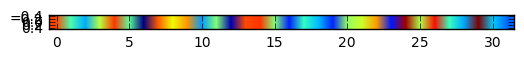

In [171]:
def run() : 
    try : 
        # get Data 
        labels_train, labels_test, data_filter_train, data_filter_test = get_test_data()
        # reset Graph
        tf.reset_default_graph()   
        # Create Session
        sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))  
        # create graph
        accuracy, x, y_target, keep_prob, train_step, merged, y, cross_entropy, summary_writer, W_conv1 = create_graph(train=True)
        # set saver
        saver = tf.train.Saver(tf.all_variables())
        # initialize the variables
        sess.run(tf.global_variables_initializer())
    
        # training the MLP
        for i in range(100): 
            sess.run(train_step, feed_dict={x: data_filter_train, y_target: labels_train, keep_prob: 0.5})
            if i%10 == 0:
                train_accuracy = sess.run(accuracy, feed_dict={x:data_filter_train, y_target: labels_train, keep_prob: 1})
                print ("step %d, training accuracy: %.3f"%(i, train_accuracy))
                
                # calculate the summary and write.
                summary = sess.run(merged, feed_dict={x:data_filter_train, y_target: labels_train, keep_prob: 1})
                summary_writer.add_summary(summary , i)
                print("summary for tensorboard written")
                
        # for given x, y_target data set
        print  ("test accuracy: %g"% sess.run(accuracy, feed_dict={x:data_filter_test, y_target: labels_test, keep_prob: 1}))
        
        # show weight matrix as image 
        weight_vectors = sess.run(W_conv1, feed_dict={x: data_filter_train, y_target: labels_train, keep_prob: 1.0})
        show_layer(weight_vectors)
        
        # Save Model
        path = './model/'
        if not os.path.exists(path):
            os.makedirs(path)
            print("path created")
        saver.save(sess, path)
        print("model saved")
    except Exception as e : 
        raise Exception ("error on training: {0}".format(e))
    finally :
        sess.close()

# run stuff
run()

# Predict Test

In [170]:
def predict(test_data) : 
    try : 
        # reset Graph
        tf.reset_default_graph()   
        # Create Session
        sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))  
        # create graph
        _, x, _, _, _, _, y, _, _, _ = create_graph(train=False)
        
        # initialize the variables
        sess.run(tf.global_variables_initializer())
        
        # set saver
        saver = tf.train.Saver()
        
        # Restore Model
        path = './model/'
        if os.path.exists(path):
            saver.restore(sess, path)
            print("model restored")

        # training the MLP
        print("input data : {0}".format(test_data))
        y = sess.run([y], feed_dict={x: np.array([test_data])})
        print("result : {0}".format(y))
        print("result : {0}".format(np.argmax(y)))
        
    except Exception as e : 
        raise Exception ("error on training: {0}".format(e))
    finally :
        sess.close()

# run stuff
predict([63.0, 1017.55, 1017.55, 24.05, 24.05, 24.05, 0.0, 1033.55])

INFO:tensorflow:Restoring parameters from ./model/
model restored
input data : [63.0, 1017.55, 1017.55, 24.05, 24.05, 24.05, 0.0, 1033.55]
result : [array([[ 1.,  0.,  0.]], dtype=float32)]
result : 0
